# PCA for Dimensionality Reduction

This script performs Principal Component Analysis (PCA) for dimensionality reduction and feature transformation on molecular descriptor datasets for both regression and classification problems. It also provides visualizations and insights into the data structure.

#### Dimensionality Reduction with PCA
- Applies PCA to reduce dimensions while retaining components that explain the majority of variance.
- Outputs a scree plot showing the variance explained by each principal component.
- Selects a fixed number of components (e.g., 15) based on the elbow of the scree plot.
- Projects the original datasets (`train`, `test`, `val`) onto the principal components to create reduced-dimensional data.
- For regression problems, adds a binary dummy variable (`is_imputed`) indicating imputed target values.

#### Visualizations
- Generates a scree plot to visualize explained variance across components.
- Creates scatter plots for the first two principal components, colored by target values or categories.
- Produces pair plots to explore relationships among the top principal components.


In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob

from matplotlib import rcParams

# Global parameters for matplotlib
rcParams['font.family'] = 'Arial'
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 18
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 20

In [2]:
input_dir = "../../3_train_test_split/"
output_dir = "PCA_results/"
transformed_dir = os.path.join(output_dir, "PCA_components/")
plots_dir = "plots"

problem_types = ["regression", "classification"]
seed = 42
n_components = 15

# Create directories if they don't exist
os.makedirs(transformed_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

In [3]:
def generate_pca_plots(X_pca_df, y_train, explained_variance_ratio, plots_dir, problem_type):
    """Generate and save plots for PCA."""
    # Scree Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label="All Components", alpha=0.5)
    plt.plot(range(1, n_components + 1), explained_variance_ratio[:n_components], marker='o', color='orange', label="Top Components")
    plt.axhline(y=0.01, color='red', linestyle='--', label="Variance Threshold = 0.01")
    plt.xlabel("Principal Component Number")
    plt.ylabel("Explained Variance Ratio")
    plt.title(f"Scree Plot ({problem_type.capitalize()})")
    plt.legend()
    plt.savefig(os.path.join(plots_dir, f"{problem_type}_PCA_Scree_Plot.png"), dpi=300)
    plt.show()

    # Scatter Plot for PC1 vs PC2
    plt.figure(figsize=(10, 8))
    if problem_type == "classification":
        palette = {"High Potency": 'blue', "Medium Potency": 'red', "Low Potency": 'green'}
        y_train = y_train.str.split("\n").str[0].str.strip()
        y_color = y_train.map(palette)
        for category, color in palette.items():
            subset = X_pca_df[y_train == category]
            plt.scatter(subset['PC1'], subset['PC2'], c=color, label=category, alpha=0.7)
        plt.legend()
    else:
        plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], c=y_train, cmap='viridis', alpha=0.7)
        plt.colorbar(label="Target Variable")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(f"PCA Scatter Plot ({problem_type.capitalize()})")
    plt.savefig(os.path.join(plots_dir, f"{problem_type}_PCA_Scatter_Plot_PC1_PC2.png"), dpi=300)
    plt.show()

    # Pair Plot for Top Components
    X_top_pcs = X_pca_df.iloc[:, :n_components].copy()
    X_top_pcs['Target'] = y_train
    pair_plot = sns.pairplot(X_top_pcs, hue='Target', diag_kind='kde',
                             palette='viridis' if problem_type == "regression" else None)
    pair_plot.fig.savefig(os.path.join(plots_dir, f"{problem_type}_PCA_PairPlot.png"), dpi=300)
    plt.show()

Processing regression data...
Explained variance ratio: [0.32343558 0.12611258 0.11569677 0.04132175 0.03784238 0.02745653
 0.02267105 0.01824014 0.01610887 0.01488748 0.01193647 0.01105603
 0.00955665 0.00871247 0.00813794]
Transformed test_reg.csv data saved to PCA_results/PCA_components/
Transformed train_reg.csv data saved to PCA_results/PCA_components/
Transformed train_reg_5.csv data saved to PCA_results/PCA_components/
Transformed train_reg_4.csv data saved to PCA_results/PCA_components/
Transformed train_reg_1.csv data saved to PCA_results/PCA_components/
Transformed train_reg_3.csv data saved to PCA_results/PCA_components/
Transformed train_reg_2.csv data saved to PCA_results/PCA_components/
Transformed val_reg_4.csv data saved to PCA_results/PCA_components/
Transformed val_reg_5.csv data saved to PCA_results/PCA_components/
Transformed val_reg_1.csv data saved to PCA_results/PCA_components/
Transformed val_reg_2.csv data saved to PCA_results/PCA_components/
Transformed val_re

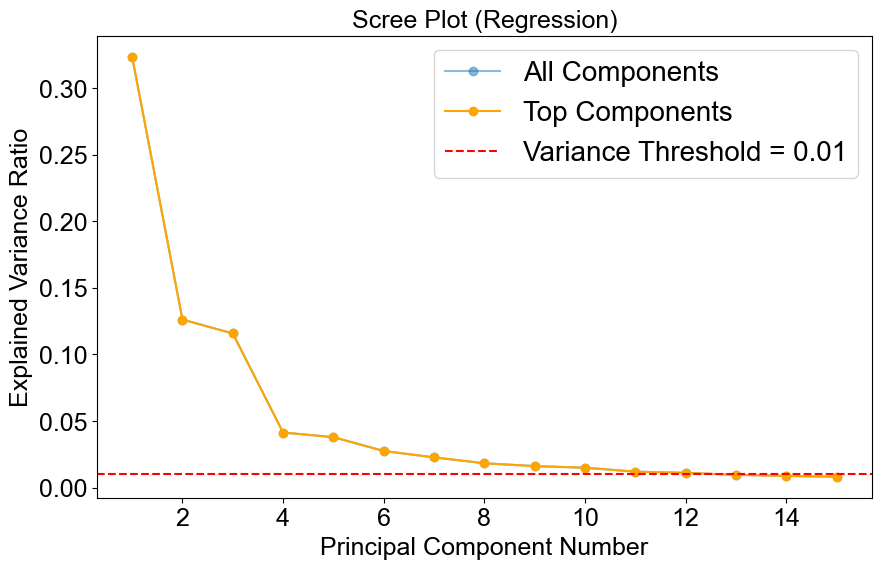

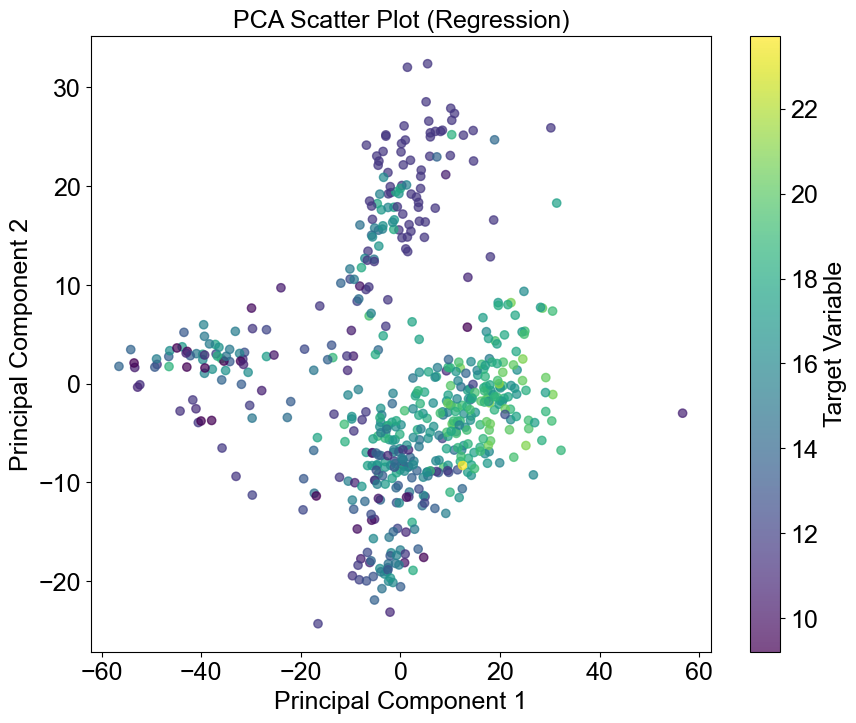

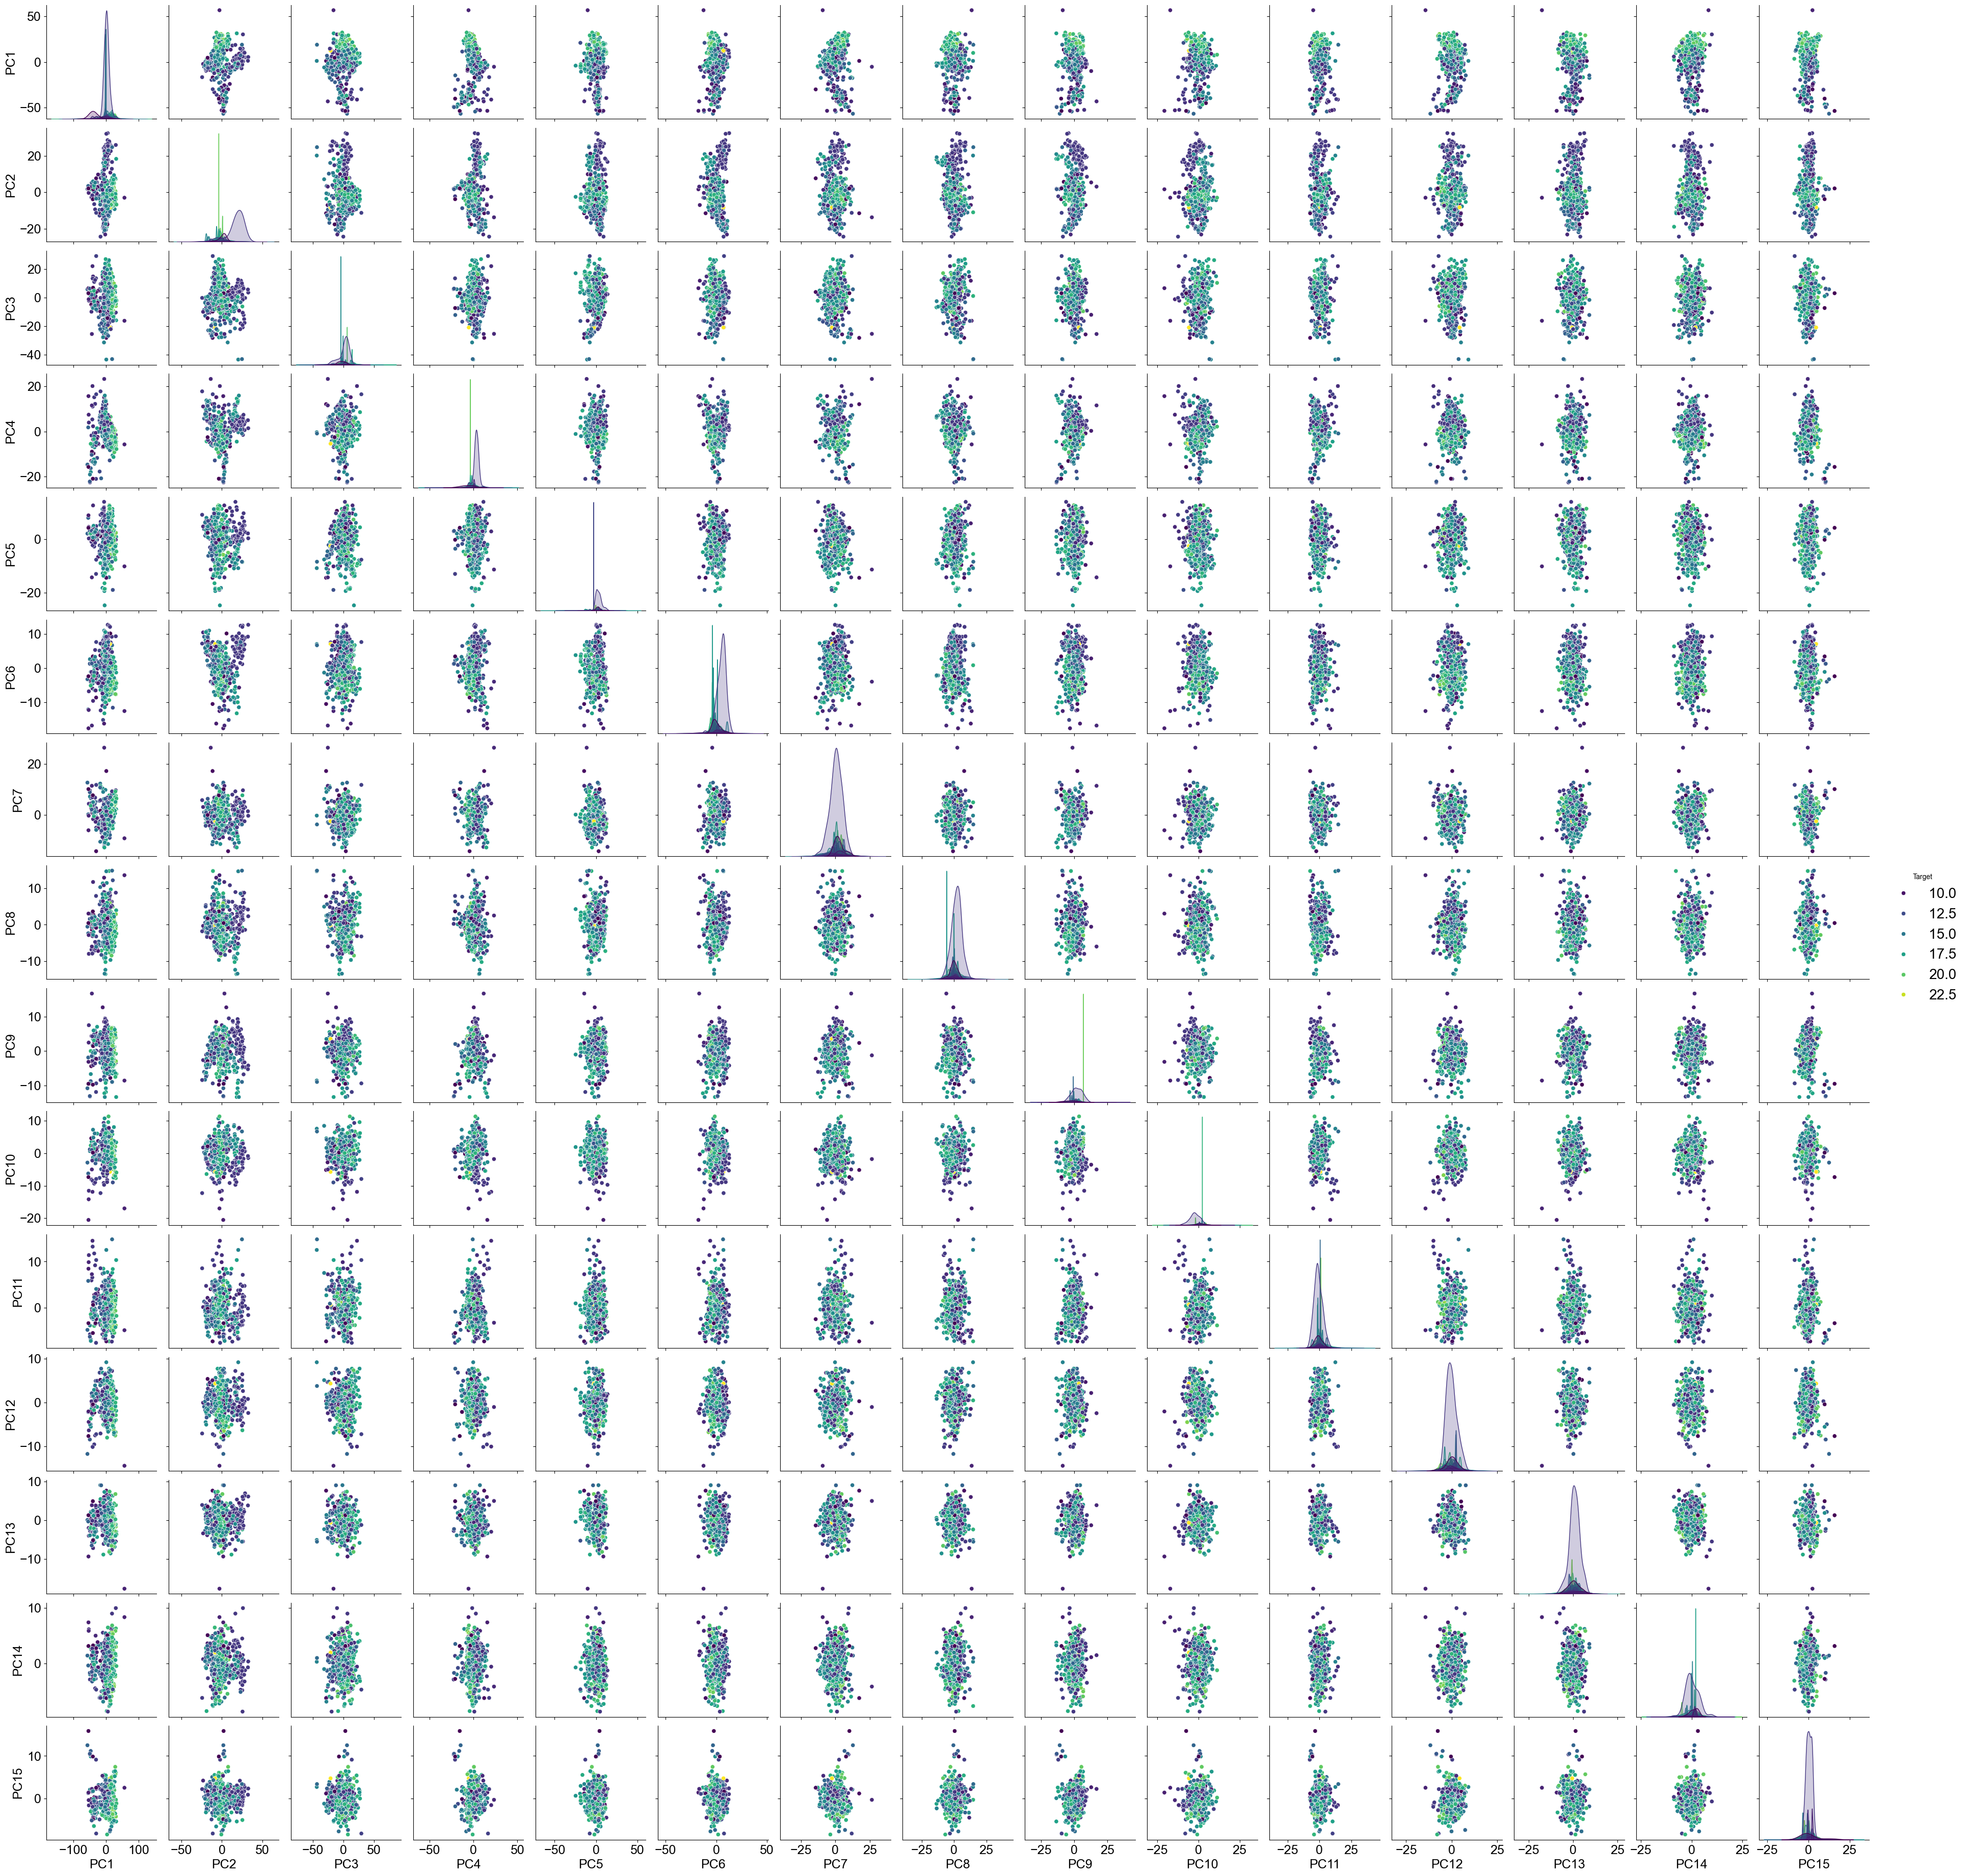

Processing classification data...
Explained variance ratio: [0.33019204 0.12519496 0.11544704 0.04091488 0.03697487 0.02609058
 0.02359988 0.01931417 0.01549012 0.01400823 0.01156074 0.01115037
 0.00978677 0.00854179 0.00826329]


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Potency
Feature names seen at fit time, yet now missing:
- AUTOCORR3D_0
- AUTOCORR3D_1
- AUTOCORR3D_10
- AUTOCORR3D_11
- AUTOCORR3D_12
- ...


In [4]:
for problem_type in problem_types:
    print(f"Processing {problem_type} data...")

    # 1. Read Data
    if problem_type == "regression":
        X = pd.read_csv(os.path.join(input_dir, "train_reg.csv")).set_index('Molecule ChEMBL ID')
        y = pd.read_csv(os.path.join(input_dir, "descriptors_all.csv")).set_index('Molecule ChEMBL ID')['-logIC50']
    elif problem_type == "classification":
        X = pd.read_csv(os.path.join(input_dir, "train_class.csv")).set_index('Molecule ChEMBL ID')
        y = pd.read_csv(os.path.join(input_dir, "descriptors_all.csv")).set_index('Molecule ChEMBL ID')['Potency']

    y_train = y.loc[X.index]

    # 2. Apply PCA
    pca = PCA(n_components=n_components, random_state=seed)
    X_pca = pca.fit_transform(X)
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio: {explained_variance_ratio[:n_components]}")

    # 3. Save PCA-transformed Data
    for file_path in glob.glob(os.path.join(input_dir, f"*_{problem_type[:3]}*")):
        # Extract the file type (train, test, val) from the filename
        file_type = os.path.basename(file_path)

        # Read the dataset
        df = pd.read_csv(file_path).set_index("Molecule ChEMBL ID")

        # Transform the data using PCA
        X_transformed = pca.transform(df)

        # Create DataFrame with top components
        transformed_df = pd.DataFrame(
            X_transformed[:, :n_components],
            index=df.index,
            columns=[f"PC{i+1}" for i in range(n_components)]
        )

        # Add dummy variable for regression
        if problem_type == "regression":
            is_imputed = (np.abs(y - (-np.log(10000 * 1e-9))) < 1e-6).astype(int)
            transformed_df['is_imputed'] = is_imputed.loc[transformed_df.index]

        # Save transformed data
        transformed_df.to_csv(os.path.join(transformed_dir, file_type))

        print(f"Transformed {file_type} data saved to {transformed_dir}")

    # 4. Generate Plots
    X_pca_df = pd.DataFrame(X_pca[:, :n_components], columns=[f"PC{i+1}" for i in range(n_components)], index=X.index)
    generate_pca_plots(X_pca_df, y_train, explained_variance_ratio, plots_dir, problem_type)